---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

## Feature Selection

In [35]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [2]:
# Define the binary target variable
df = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
df['points_category'] = df['position'].apply(lambda x: 1 if x <= 10 else 0)


In [3]:
df.head()

,Unnamed: 0,Year,Round,RaceName,DriverID,Lap1,Lap2,Lap3,Lap4,Lap5,...,Duration2,Duration3,Duration4,Duration5,Duration6,Duration7,constructorName,position,grid,points_category
0,0,2011,1,Australian Grand Prix,alguersuari,-1.492522,-0.208201,1.339923,-0.281099,-0.15023,...,0.733521,1.882538,-0.277274,-0.130754,-0.060017,-0.01976,AlphaTauri,11.0,12.0,0
1,1,2011,1,Australian Grand Prix,alonso,-0.414215,0.355923,1.723412,-0.281099,-0.15023,...,0.755727,1.679973,-0.277274,-0.130754,-0.060017,-0.01976,Ferrari,4.0,5.0,1
2,2,2011,1,Australian Grand Prix,ambrosio,-0.218159,0.976458,-0.577525,-0.281099,-0.15023,...,0.896614,-0.580401,-0.277274,-0.130754,-0.060017,-0.01976,Marussia,14.0,22.0,0
3,3,2011,1,Australian Grand Prix,barrichello,-0.316187,0.130273,0.956433,3.039918,-0.15023,...,1.835036,0.998617,3.860649,-0.130754,-0.060017,-0.01976,Williams,16.0,17.0,0
4,4,2011,1,Australian Grand Prix,buemi,-0.120131,0.468747,-0.577525,-0.281099,-0.15023,...,0.621420,-0.580401,-0.277274,-0.130754,-0.060017,-0.01976,AlphaTauri,8.0,10.0,1


In [4]:
# Define features and target
features = [
    "Year",
    "Lap1", "Lap2", "Lap3", "Lap4", "Lap5",
    "Stop1", "Stop2", "Stop3", "Stop4", "Stop5", 
    "Duration1", "Duration2", "Duration3", "Duration4", "Duration5",
    "Duration6", "Duration7", "grid"
]
X = df[features]
y = df["points_category"]  


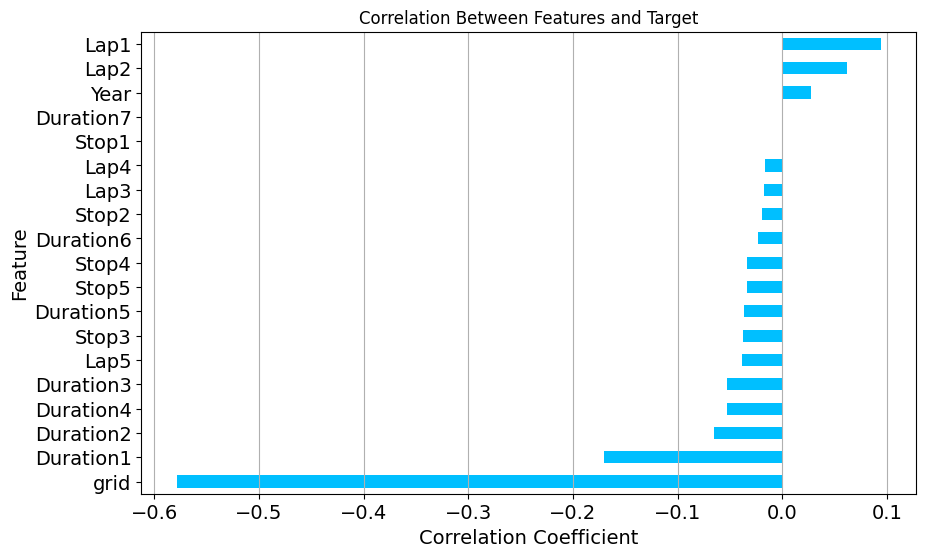

In [5]:
# 1. Correlation Analysis
plt.figure(figsize=(10, 6))
correlations = X.corrwith(y)
correlations.sort_values().plot(kind='barh', color='deepskyblue')
plt.title("Correlation Between Features and Target")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x')
plt.show()

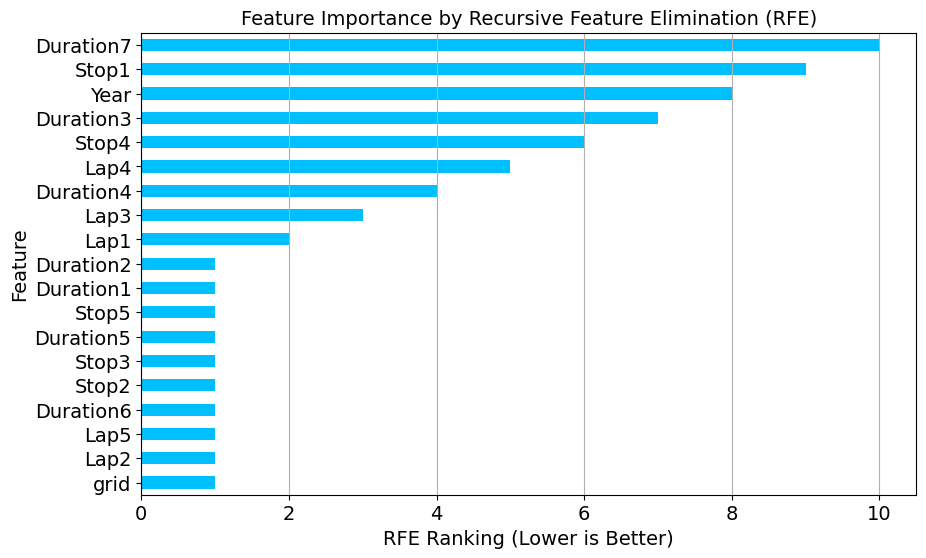

In [6]:
# 2. Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
rfe_ranking = pd.Series(rfe.ranking_, index=features).sort_values()

plt.figure(figsize=(10, 6))
rfe_ranking.plot(kind='barh', color='deepskyblue')
plt.title("Feature Importance by Recursive Feature Elimination (RFE)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("RFE Ranking (Lower is Better)", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x')
plt.show()

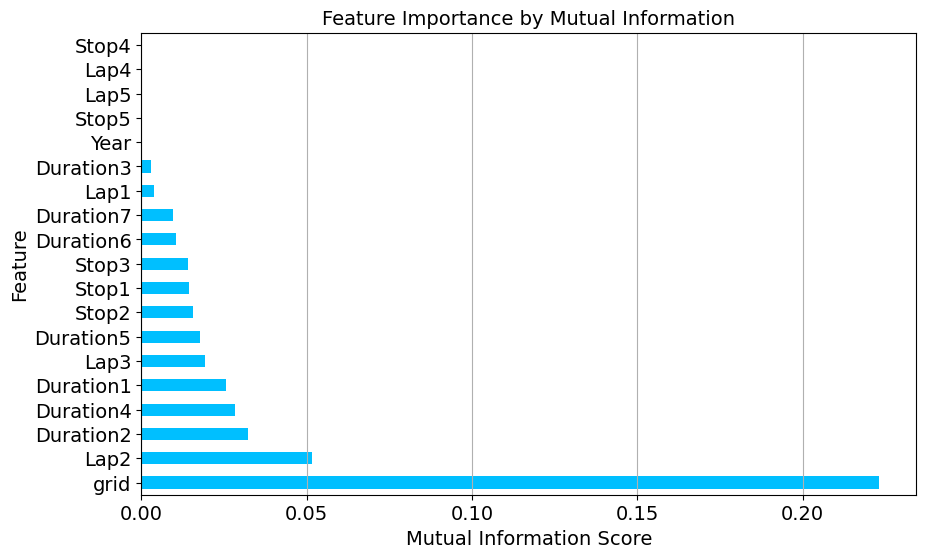

In [7]:
# 3. Mutual Information
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_series = pd.Series(mutual_info, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='barh', color='deepskyblue')
plt.title("Feature Importance by Mutual Information", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xlabel("Mutual Information Score", fontsize=14)
plt.grid(axis='x')
plt.show()

features:
grid, Year, Duration1, Duration2, Duration3, Duration4, Lap1, Lap2, Lap3, Stop2

## Binary Classification

### Decision Trees

In [9]:
df_transformed = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
df_transformed['points_category'] = df_transformed['position'].apply(lambda x: 1 if x <= 10 else 0)
X = df_transformed[['grid', 'Year', 'Duration1', 'Duration2', 'Duration3', 'Duration4', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3', 'Stop4']]
y = df_transformed['points_category']  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [10]:
# decision tree
X = df_transformed[['grid', 'Year', 'Duration1', 'Duration2', 'Duration3', 'Duration4', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3', 'Stop4']]
y = df_transformed['points_category']  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       114
           1       0.76      0.69      0.72       128

    accuracy                           0.72       242
   macro avg       0.72      0.72      0.72       242
weighted avg       0.72      0.72      0.72       242



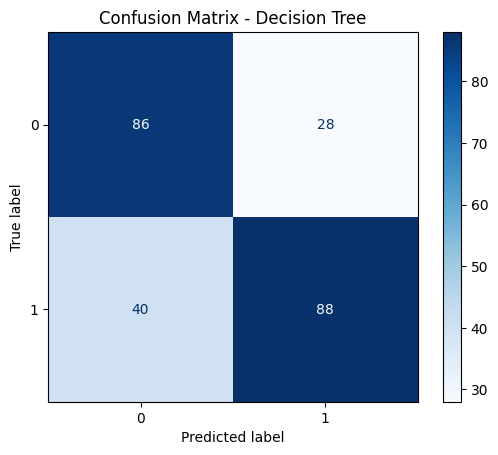

In [11]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the model
dt.fit(X_train, y_train)

# Predict on test set
y_pred = dt.predict(X_test)

# Evaluation Metrics
print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report - Optimized Decision Tree:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       114
           1       0.80      0.78      0.79       128

    accuracy                           0.78       242
   macro avg       0.78      0.78      0.78       242
weighted avg       0.78      0.78      0.78       242



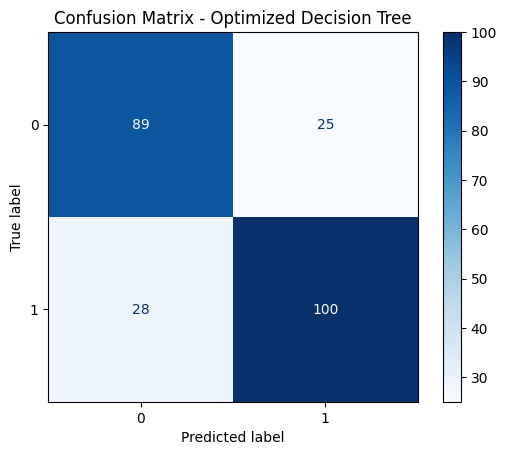

In [12]:
# Define the parameter grid
param_grid = {
    'max_depth': range(1, 21),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Perform Grid Search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)

# Evaluation Metrics for Best Model
print("Classification Report - Optimized Decision Tree:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Optimized Decision Tree")
plt.show()


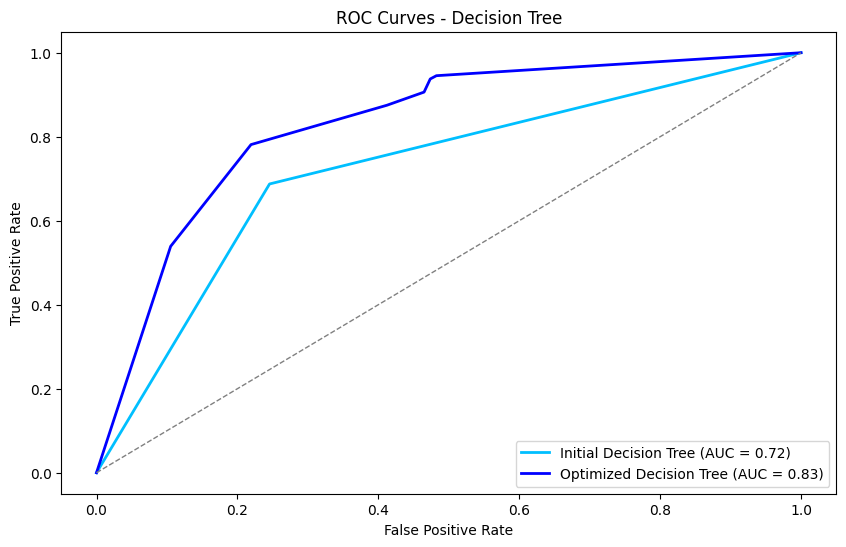

In [13]:
# ROC Curve for the Initial Decision Tree
y_proba_initial = dt.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_proba_initial)
roc_auc_initial = auc(fpr_initial, tpr_initial)

# ROC Curve for the Optimized Decision Tree
y_proba_optimized = best_dt.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_proba_optimized)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_initial, tpr_initial, label=f'Initial Decision Tree (AUC = {roc_auc_initial:.2f})', color='deepskyblue', lw=2)
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Decision Tree (AUC = {roc_auc_optimized:.2f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Decision Tree')
plt.legend(loc="lower right")
plt.show()


### Random Forest

In [14]:
df_transformed = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
df_transformed['points_category'] = df_transformed['position'].apply(lambda x: 1 if x <= 10 else 0)
X = df_transformed[['grid', 'Year', 'Duration1', 'Duration2', 'Duration3', 'Duration4', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3', 'Stop4']]
y = df_transformed['points_category']  

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       114
           1       0.81      0.79      0.80       128

    accuracy                           0.79       242
   macro avg       0.79      0.79      0.79       242
weighted avg       0.79      0.79      0.79       242



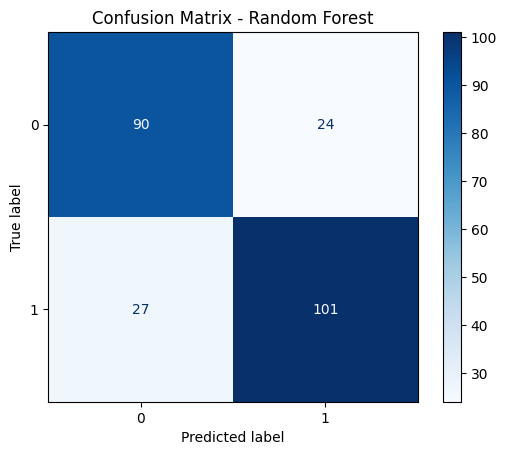

Accuracy: 0.7892561983471075


In [23]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=123)

# Train the model
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Accuracy Score
print("Accuracy:", accuracy_score(y_test, y_pred))


In [24]:
# Define hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=123),
                           param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate with best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Classification Report
print("Classification Report - Optimized Random Forest:")
print(classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report - Optimized Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       114
           1       0.80      0.80      0.80       128

    accuracy                           0.79       242
   macro avg       0.79      0.79      0.79       242
weighted avg       0.79      0.79      0.79       242



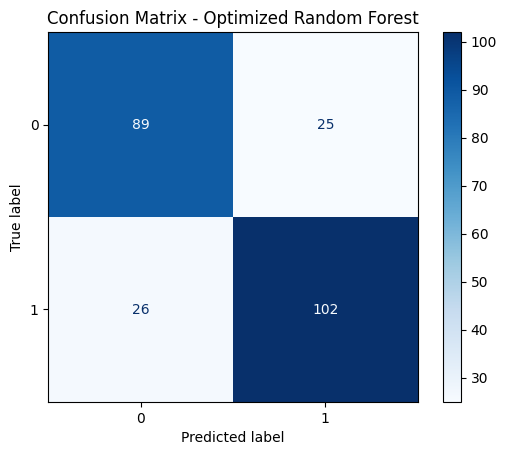

In [25]:
# Confusion Matrix for Optimized Random Forest
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Optimized Random Forest")
plt.show()

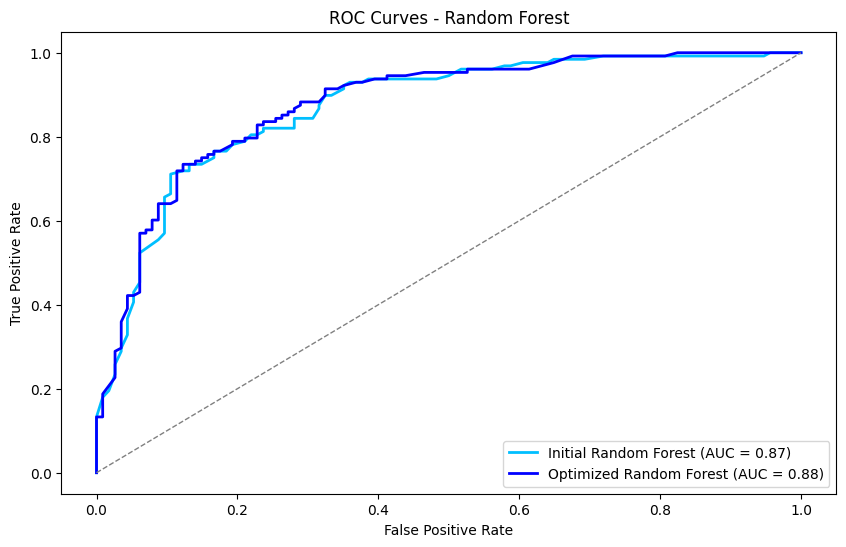

In [26]:
# ROC Curve for the Initial Random Forest
y_proba_initial = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_proba_initial)
roc_auc_initial = auc(fpr_initial, tpr_initial)

# ROC Curve for the Optimized Random Forest
y_proba_optimized = best_rf.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_proba_optimized)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_initial, tpr_initial, label=f'Initial Random Forest (AUC = {roc_auc_initial:.2f})', color='deepskyblue', lw=2)
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Random Forest (AUC = {roc_auc_optimized:.2f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Random Forest')
plt.legend(loc="lower right")
plt.show()


## Multiclass Classification

In [27]:
# Create a new column with binned classes based on 'position'
def position_to_class(position):
    if 1 <= position <= 5:
        return 1
    elif 6 <= position <= 10:
        return 2
    elif 11 <= position <= 15:
        return 3
    elif 16 <= position <= 20:
        return 4
    else:
        return None  

df_transformed['position_class'] = df_transformed['position'].apply(position_to_class)

df_transformed = df_transformed.dropna(subset=['position_class'])

# Define features and target
X = df_transformed[['grid', 'Year', 'Duration1', 'Duration2', 'Duration3', 'Duration4', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3', 'Stop4']]
y = df_transformed['position_class']


In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)


Classification Report - Multi-class Random Forest:
              precision    recall  f1-score   support

         1.0       0.67      0.77      0.71        65
         2.0       0.38      0.41      0.40        63
         3.0       0.40      0.38      0.39        61
         4.0       0.50      0.37      0.42        46

    accuracy                           0.49       235
   macro avg       0.49      0.48      0.48       235
weighted avg       0.49      0.49      0.49       235



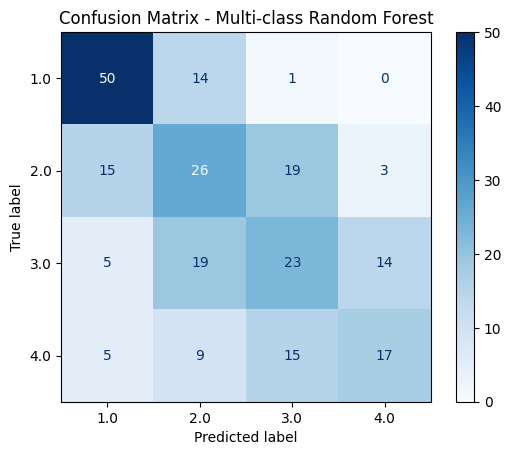

In [30]:
# Initialize Random Forest Classifier
rf_multi = RandomForestClassifier(random_state=42)

# Train the model
rf_multi.fit(X_train, y_train)

# Predict
y_pred_multi = rf_multi.predict(X_test)

# Evaluation Metrics
print("Classification Report - Multi-class Random Forest:")
print(classification_report(y_test, y_pred_multi))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_multi, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Multi-class Random Forest")
plt.show()


Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report - Optimized Multi-class Random Forest:
              precision    recall  f1-score   support

         1.0       0.66      0.74      0.70        65
         2.0       0.37      0.40      0.38        63
         3.0       0.41      0.46      0.43        61
         4.0       0.50      0.28      0.36        46

    accuracy                           0.49       235
   macro avg       0.48      0.47      0.47       235
weighted avg       0.49      0.49      0.48       235



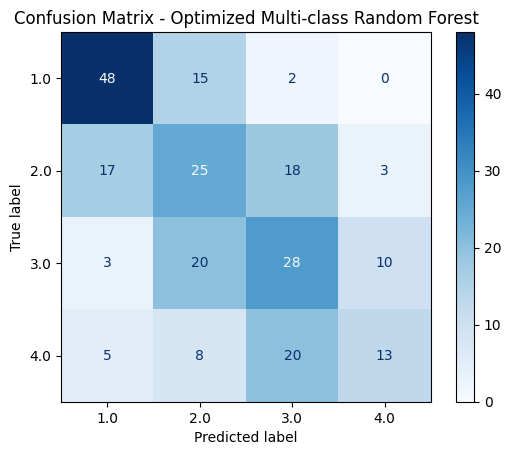

In [31]:
# Define hyperparameters
param_grid_multi = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search
grid_search_multi = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                 param_grid=param_grid_multi, cv=5, scoring='accuracy')
grid_search_multi.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search_multi.best_params_)

# Evaluate with best parameters
best_rf_multi = grid_search_multi.best_estimator_
y_pred_best_multi = best_rf_multi.predict(X_test)

# Classification Report
print("Classification Report - Optimized Multi-class Random Forest:")
print(classification_report(y_test, y_pred_best_multi))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_rf_multi, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Optimized Multi-class Random Forest")
plt.show()
